In [1]:
!pip install ujson

import os
import pickle
import pandas as pd
import numpy as np
import ujson as json
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from functools import partial
from collections import OrderedDict

from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LinearRegression

     |████████████████████████████████| 194kB 4.8MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68710 sha256=9e8d0e4645c3b27d33ec7b46a65b6435e60ea1cf15b1b5c8b5c25952c1dc58e7
  Stored in directory: /tmp/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson


In [2]:
PATH_TO_DATA = '../input/'
SEED = 17
SIZE = None

In [3]:
def replace_na(df):
    df[np.isnan(df)] = 0
    df[np.isinf(df)] = 0
    return df

In [4]:
def read_matches(matches_file, size=None):
    with open(os.path.join(PATH_TO_DATA, matches_file)) as f:
        count = 0
        for line in f:
            if size is not None and count >= size:
                return
            count += 1
            yield json.loads(line)

In [5]:
def count_ruined_towers(match):
    radiant_tower_kills = 0
    dire_tower_kills = 0
    for objective in match['objectives']:
        if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
            if objective['team'] == 2:
                radiant_tower_kills += 1
            if objective['team'] == 3:
                dire_tower_kills += 1
    return radiant_tower_kills, dire_tower_kills, radiant_tower_kills-dire_tower_kills

In [6]:
def ratio_numeric_features(df, features):
    for feature in features:
        for team in 'r', 'd':
            cols = [f'{team}{i}_{feature}' for i in range(1, 6)]
            df[f'{team}_{feature}_std'] = df[cols].std(axis=1)
            df[f'{team}_{feature}_mean'] = df[cols].mean(axis=1)
            df.drop(columns=cols, inplace=True)
        
        df[f'{feature}_std_ratio'] = df[f'r_{feature}_std'] / df[f'd_{feature}_std']
        df[f'{feature}_mean_ratio'] = df[f'r_{feature}_mean'] / df[f'd_{feature}_mean']

        df.drop(columns=[
            f'r_{feature}_std', f'd_{feature}_std',
            f'r_{feature}_mean', f'd_{feature}_mean'
        ], inplace=True)

    return df

In [7]:
def get_game_time(match):
    if match['game_time'] == 0:
        return [match['players'][0]['times'][-1]]
    else:
        return [match['game_time']]

In [8]:
def tri_state_hero(df):
    hero_ids = df['r1_hero_id'].unique()
    tmp = pd.DataFrame(
        columns=[f'{i}_hero_id' for i in hero_ids],
        index=df.index
    ).fillna(0)

    for hero_id in hero_ids:
        for team in ('r', 'd'):
            tmp.loc[
                (df[f'{team}1_hero_id'] == hero_id) |
                (df[f'{team}2_hero_id'] == hero_id) |
                (df[f'{team}3_hero_id'] == hero_id) |
                (df[f'{team}4_hero_id'] == hero_id) |
                (df[f'{team}5_hero_id'] == hero_id),
                f'{hero_id}_hero_id'
            ] = 1 if team == 'r' else -1

    drop_cols = [f'{team}{i}_hero_id' for team in ('r', 'd') for i in range(1, 6)]
    df.drop(columns=drop_cols, inplace=True)

    return pd.concat([df, tmp], axis=1)

In [9]:
MATCH_FEATURES = [
    (['game_time'], get_game_time),
    (['game_mode'], lambda m: [m['game_mode']]),
    (['lobby_type'], lambda m: [m['lobby_type']]),
    (['objectives_len'], lambda m: [len(m['objectives'])]),
    (['chat_len'], lambda m: [len(m['chat'])]),
    (['radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills'],
     count_ruined_towers),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',

    'stuns',
    'teamfight_participation',
    'rune_pickups',
    'obs_placed',
    'sen_placed',
    'creeps_stacked',
    'camps_stacked',
    'firstblood_claimed',
    'towers_killed',
    'roshans_killed',
]

def extract_features_csv(match):
    row = [('match_id_hash', match['match_id_hash'])]

    for fields, func in MATCH_FEATURES:
        row.extend(zip(fields, func(match)))
        
    for slot, player in enumerate(match['players']):
        player_name = f'r{slot + 1}' if slot < 5 else f'd{slot - 4}'
        for field in PLAYER_FIELDS:
            column_name = f'{player_name}_{field}'
            row.append((column_name, player[field]))

        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))

    return OrderedDict(row)

In [10]:
def get_features_df(matches_file, size=SIZE):
    csv_rows = [
        extract_features_csv(match)
        for match in read_matches(matches_file, size=size)
    ]
    df = pd.DataFrame.from_records(csv_rows).set_index('match_id_hash')
    
    df = tri_state_hero(df)

    numeric_features = [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'health',
        'max_health', 'max_mana', 'level', 'stuns', 'lh', 'rune_pickups',
        'teamfight_participation', 'obs_placed', 'sen_placed', 'ability_level', 
        'max_hero_hit', 'purchase_count', 'count_ability_use', 'damage_dealt', 'damage_received',
        'firstblood_claimed',  'roshans_killed', 'towers_killed', 'creeps_stacked', 'camps_stacked',
    ]
    df = replace_na(ratio_numeric_features(df, numeric_features))

    return df

In [11]:
df_train = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'train_features.csv'), 
    index_col='match_id_hash'
)[:SIZE]
df_targets = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'train_targets.csv'), 
    index_col='match_id_hash'
)[:SIZE]

y = df_targets['radiant_win'].map({True: 1, False: 0})
X = get_features_df('train_matches.jsonl')

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

cat_features = [
    'objectives_len', 'game_mode',
    'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills',
]
cat_features_idx = [X.columns.get_loc(i) for i in cat_features]

In [13]:
X.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,radiant_tower_kills,dire_tower_kills,diff_tower_kills,r1_x,r1_y,...,firstblood_claimed_std_ratio,firstblood_claimed_mean_ratio,roshans_killed_std_ratio,roshans_killed_mean_ratio,towers_killed_std_ratio,towers_killed_mean_ratio,creeps_stacked_std_ratio,creeps_stacked_mean_ratio,camps_stacked_std_ratio,camps_stacked_mean_ratio
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0,0,0,116,122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,2,0,2,76,78,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.816497,0.5
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0,0,0,118,118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0,0,0,170,96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0,0,0,80,164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [14]:
params = {
    'eval_metric': 'AUC',
    'custom_loss': ['AUC'],
    'random_state': SEED,
    'bagging_temperature': 0.0,
    'border_count': 255,
    'depth': 8,
    'iterations': 1000,
    'l2_leaf_reg': 30,
    'learning_rate': 0.036778105553030696,
    'random_strength': 0.0011406276175633515,
    'scale_pos_weight': 1.0
}
model = CatBoostClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features_idx,
    plot=True,
    verbose=False
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
print(model.best_score_['validation']['AUC'])

0.8382450847824974


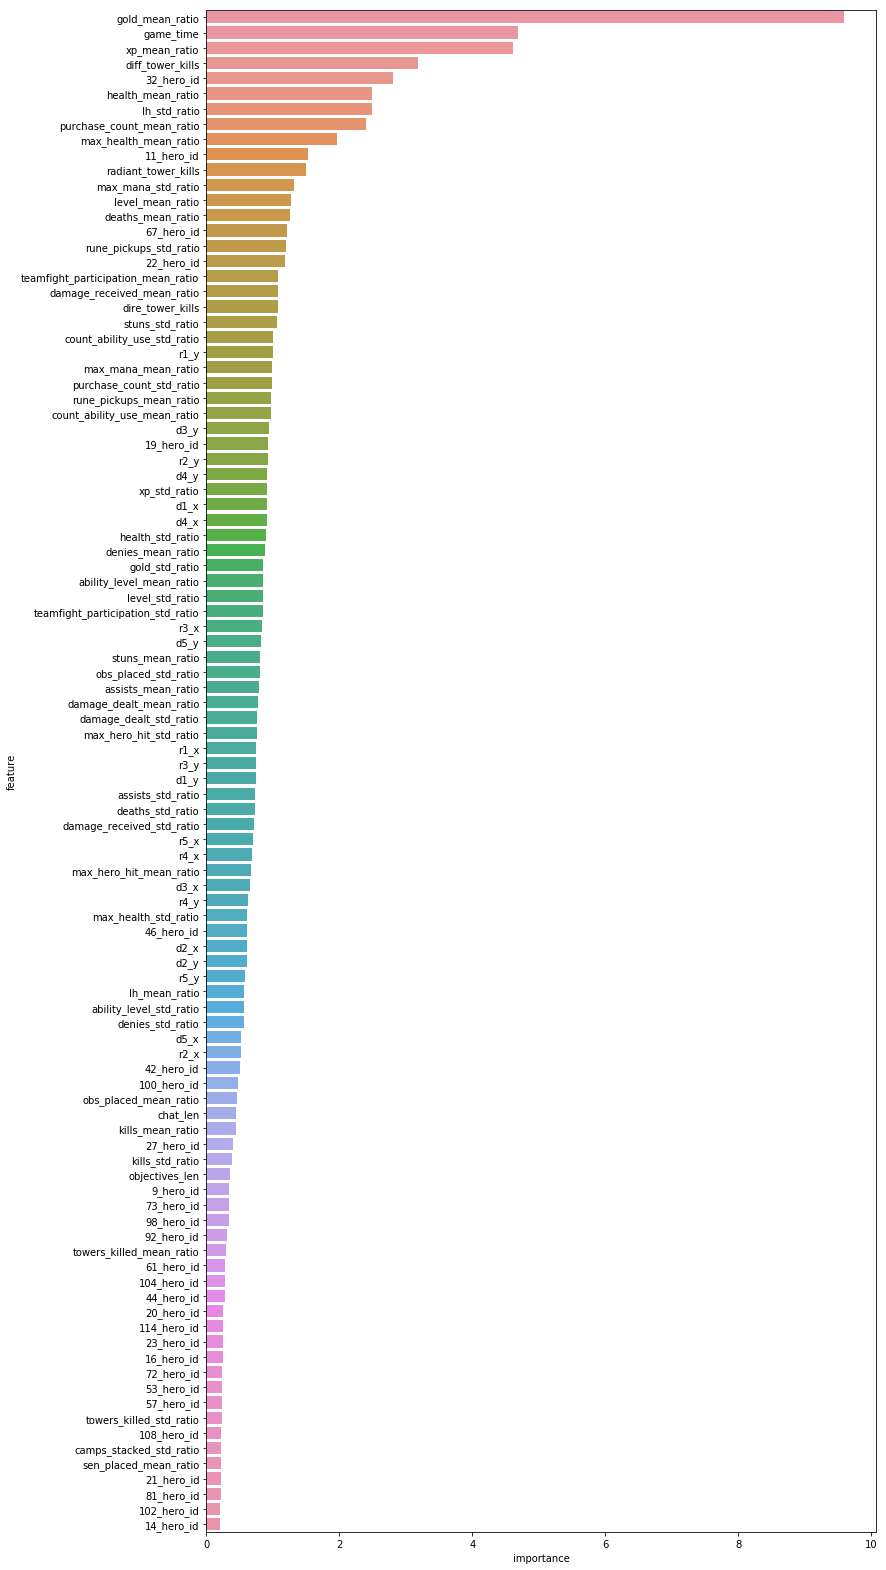

In [16]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)[:100]

plt.figure(figsize=(12,28))
sns.barplot(x=feature_importance.importance, y=feature_importance.feature);

In [17]:
df_test = get_features_df('test_matches.jsonl')
model.fit(
    X, y,
    cat_features=cat_features_idx,
    verbose=False
)
y_pred = model.predict_proba(df_test)[:, 1]
pd.DataFrame({'radiant_win_prob': y_pred}, index=df_test.index).to_csv('submission.csv')

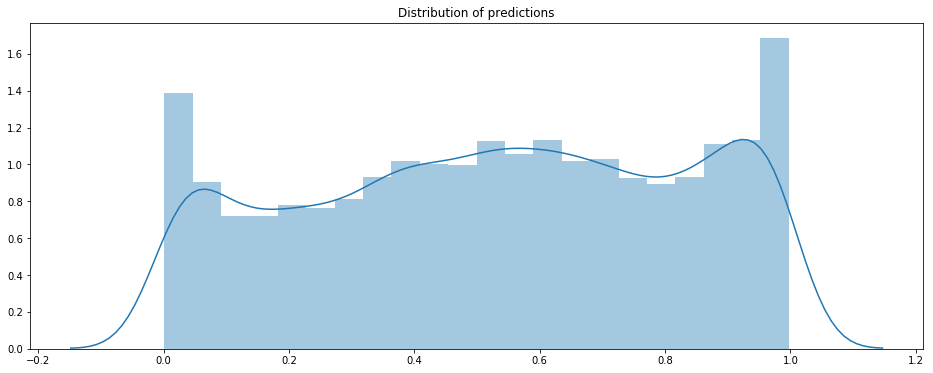

In [18]:
plt.figure(figsize=(16, 6))
sns.distplot(y_pred).set_title('Distribution of predictions');